# Class

In [37]:
import os
import random
import cv2
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import csv

class CellAnimationGenerator:
    def __init__(self):
        self.background_patches = []
        self.cell_patches = []

    def load_assets(self, bg_folder, cell_folder):
        def load_patches(folder):
            images = []
            for f in os.listdir(folder):
                if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(os.path.join(folder, f))
                    if img is not None:
                        images.append(img)
            return images

        self.background_patches = load_patches(bg_folder)
        self.cell_patches = load_patches(cell_folder)

        if not self.background_patches:
            raise ValueError("No background images found!")
        if not self.cell_patches:
            raise ValueError("No cell images found!")

    def generate_background(self, output_size=(450, 450)):
        h, w = output_size
        base_patch = random.choice(self.background_patches)
        base_patch = cv2.resize(base_patch, (w, h))
        background = base_patch.copy()

        for _ in range(random.randint(6, 10)):
            patch = random.choice(self.background_patches)
            patch_size = random.randint(min(h,w)//3, min(h,w)//2)
            patch = cv2.resize(patch, (patch_size, patch_size))

            angle = random.uniform(0, 360)
            M = cv2.getRotationMatrix2D((patch_size//2, patch_size//2), angle, 1)
            patch = cv2.warpAffine(patch, M, (patch_size, patch_size))

            patch = cv2.convertScaleAbs(patch, alpha=random.uniform(0.8, 1.2), beta=random.randint(-20, 20))

            x = random.randint(-patch_size//3, w - patch_size//3*2)
            y = random.randint(-patch_size//3, h - patch_size//3*2)

            mask = np.ones((patch_size, patch_size, 3), dtype=np.float32)
            cv2.circle(mask, (patch_size//2, patch_size//2), patch_size//2, (1,1,1), -1)
            mask = cv2.GaussianBlur(mask, (51, 51), 0)
            mask *= random.uniform(0.3, 0.7)

            try:
                y_start = max(y, 0)
                y_end = min(y+patch_size, h)
                x_start = max(x, 0)
                x_end = min(x+patch_size, w)

                patch_y_start = max(-y, 0)
                patch_y_end = patch_y_start + (y_end - y_start)
                patch_x_start = max(-x, 0)
                patch_x_end = patch_x_start + (x_end - x_start)

                mask_roi = mask[patch_y_start:patch_y_end, patch_x_start:patch_x_end]

                background[y_start:y_end, x_start:x_end] = \
                    background[y_start:y_end, x_start:x_end] * (1 - mask_roi) + \
                    patch[patch_y_start:patch_y_end, patch_x_start:patch_x_end] * mask_roi
            except Exception as e:
                print(f"Error blending patch: {e}")
                continue

        return cv2.GaussianBlur(background, (15, 15), 0)

    def overlay_cell(self, bg, cell, position):
        x_center, y_center = position
        h, w = cell.shape[:2]
        x = int(x_center - w/2)
        y = int(y_center - h/2)

        if x < 0 or y < 0 or x+w > bg.shape[1] or y+h > bg.shape[0]:
            return bg

        mask = np.zeros((h, w, 3), dtype=np.float32)
        cv2.circle(mask, (w//2, h//2), min(w,h)//2, (1,1,1), -1)
        mask = cv2.GaussianBlur(mask, (25, 25), 0)

        result = bg.copy()
        try:
            result[y:y+h, x:x+w] = result[y:y+h, x:x+w] * (1 - mask) + cell * mask
        except Exception as e:
            print(f"Error overlaying cell: {e}")
        return result

class CellTracker:
    def __init__(self, fps):
        self.trajectories = []
        self.current_id = 0
        self.fps = fps
        os.makedirs('debug_frames', exist_ok=True)

    def add_position(self, frame_idx, cell_id, x, y):
        self.trajectories.append({
            'frame': frame_idx,
            'time': frame_idx / self.fps,
            'cell_id': cell_id,
            'x': x,
            'y': y
        })

    def save_csv(self, filename):
        with open(filename, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=['frame', 'time', 'cell_id', 'x', 'y'])
            writer.writeheader()
            writer.writerows(self.trajectories)

    def visualize_trajectories(self, background, output_file):
        img = background.copy()
        colors = plt.cm.get_cmap('tab20', 20).colors[:, :3]*255

        for cell_id in set(t['cell_id'] for t in self.trajectories):
            points = [(int(t['x']), int(t['y'])) for t in self.trajectories if t['cell_id'] == cell_id]
            if len(points) < 2:
                continue

            color = colors[cell_id % len(colors)]
            cv2.polylines(img, [np.array(points)], False, color, 2)
            cv2.circle(img, points[0], 5, color, -1)
            cv2.circle(img, points[-1], 5, color, -1)
            cv2.putText(img, str(cell_id), (points[-1][0]+10, points[-1][1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        plt.figure(figsize=(12, 12))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title('Cell Trajectories Visualization')
        plt.axis('off')
        plt.show()
        plt.savefig(output_file, bbox_inches='tight')
        # plt.close()

    def overlay_trajectories_on_frame(self, frame, output_file):
        img = frame.copy()
        colors = plt.cm.get_cmap('tab20', 20).colors[:, :3]*255

        for cell_id in set(t['cell_id'] for t in self.trajectories):
            points = [(int(t['x']), int(t['y'])) for t in self.trajectories if t['cell_id'] == cell_id]
            if len(points) < 2:
                continue

            color = colors[cell_id % len(colors)]
            cv2.polylines(img, [np.array(points)], False, color, 2)
            cv2.circle(img, points[0], 5, color, -1)
            cv2.circle(img, points[-1], 5, color, -1)
            cv2.putText(img, str(cell_id), (points[-1][0]+10, points[-1][1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

        cv2.imwrite(output_file, img)

def generate_animation(
    bg_folder="content/fon",
    cell_folder="content/cells",
    output_file="output.mp4",
    duration=10,
    fps=24,
    num_cells=8
):
    generator = CellAnimationGenerator()
    generator.load_assets(bg_folder, cell_folder)

    tracker = CellTracker(fps)
    canvas_size = (450, 450)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_file, fourcc, fps, canvas_size)

    background = generator.generate_background(canvas_size)
    active_cells = []
    total_frames = duration * fps
    final_frame = None
    next_cell_id = 0  # 🔧 Новый счётчик ID

    for frame_idx in tqdm(range(total_frames), desc="Generating Animation"):
        frame = background.copy()
        current_time = frame_idx / fps

        if len(active_cells) < num_cells and frame_idx % (fps//2) == 0:
            cell_img = random.choice(generator.cell_patches)
            size = random.randint(40, 80)
            cell_img = cv2.resize(cell_img, (size, size))

            if random.random() > 0.5:
                hsv = cv2.cvtColor(cell_img, cv2.COLOR_BGR2HSV)
                hsv[:, :, 0] = (hsv[:, :, 0] + random.randint(-10, 10)) % 180
                hsv[:, :, 1] = np.clip(hsv[:, :, 1] * random.uniform(0.8, 1.2), 0, 255)
                cell_img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

            active_cells.append({
                'id': next_cell_id,
                'image': cell_img,
                'x0': random.uniform(0, canvas_size[0]),
                'y0': random.uniform(0, canvas_size[1]),
                'velocity': random.uniform(5, 15),
                'amplitude': random.uniform(10, 30),
                'frequency': random.uniform(0.05, 0.2),
                'noise_level': random.uniform(1, 3),
                'angle': random.uniform(0, 2 * math.pi),
                'life': 0
            })
            next_cell_id += 1  # 🆕 Увеличиваем уникальный ID

        for cell in active_cells[:]:
            cell['life'] += 1 / fps
            t = current_time
            dx = cell['velocity'] * t
            dy = (cell['amplitude'] * math.sin(cell['frequency'] * dx) +
                  cell['noise_level'] * math.sin(t * 5 + cell['angle']))

            x = cell['x0'] + dx
            y = cell['y0'] + dy

            if (x < -100 or x > canvas_size[0] + 100 or
                y < -100 or y > canvas_size[1] + 100 or
                cell['life'] > duration * 0.8):
                active_cells.remove(cell)
                continue

            frame = generator.overlay_cell(frame, cell['image'], (x, y))
            tracker.add_position(frame_idx, cell['id'], x, y)

        if frame_idx == total_frames - 1:
            final_frame = frame.copy()

        video_writer.write(frame)

    video_writer.release()
    tracker.save_csv('trajectories.csv')
    tracker.visualize_trajectories(background, 'trajectories_visualization.png')

    if final_frame is not None:
        tracker.overlay_trajectories_on_frame(final_frame, 'trajectories_output.png')

    print(f"✅ Animation saved to {output_file}")
    print("📌 Trajectories: 'trajectories_visualization.png' & 'trajectories_output.png'")


# Run

Generating Animation: 100%|██████████| 240/240 [00:00<00:00, 1577.70it/s]
/var/folders/fm/__xjg2_1199f_fdhggm2cgd40000gn/T/ipykernel_81365/3998785263.py:124: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 20).colors[:, :3]*255


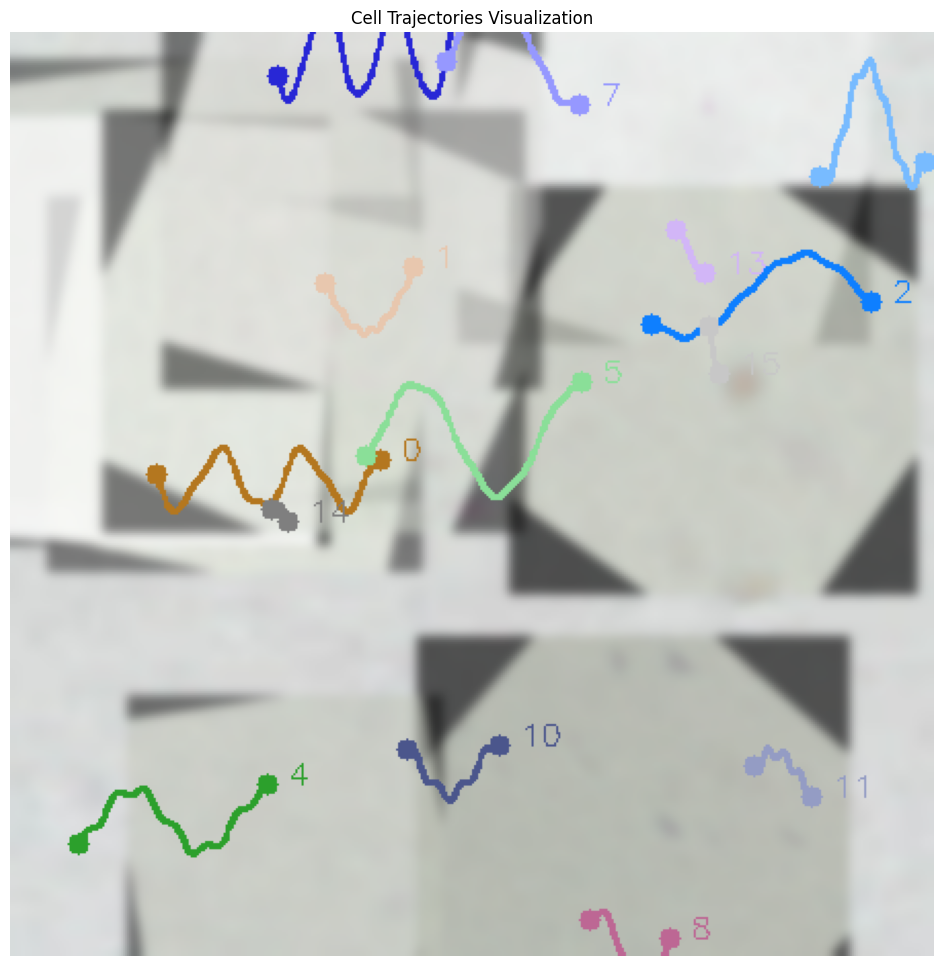

✅ Animation saved to cell_animation.mp4
📌 Trajectories: 'trajectories_visualization.png' & 'trajectories_output.png'


/var/folders/fm/__xjg2_1199f_fdhggm2cgd40000gn/T/ipykernel_81365/3998785263.py:147: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', 20).colors[:, :3]*255


<Figure size 640x480 with 0 Axes>

In [38]:
if __name__ == "__main__":
    generate_animation(
        bg_folder="/Users/nident/Desktop/RSREU/МФТИ/2семак/blood_cells_dataset/fon",
        cell_folder="/Users/nident/Desktop/RSREU/МФТИ/2семак/blood_cells_dataset/patch",
        output_file="cell_animation.mp4",
        duration=10,
        fps=24,
        num_cells=12
    )